In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn # building metwork for neural network
import sklearn
import torch

In [106]:
from sklearn.datasets import make_circles

In [107]:
n_sample = 1000
X, y = make_circles(n_sample,noise = 0.03, random_state=42)
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [108]:
circles = pd.DataFrame({"X1": X[:,0],"X2": X[:,1], "Y": y[:]})
circles

,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


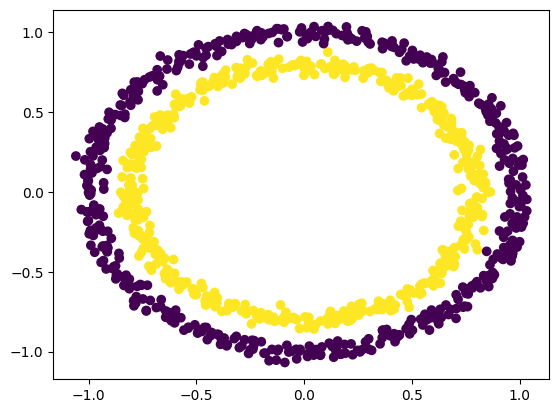

In [109]:
plt.scatter(x = X[:,0],y = X[:,1], c = y)

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(X).type(torch.float), torch.tensor(y).type(torch.float), test_size=0.2, random_state=42)

In [111]:
 device = "cuda" if torch.cuda.is_available else "cpu"
 device

'cuda'

In [112]:
class CircleModeV1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x:torch.Tensor):
    z  =self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return z
model_1 = CircleModeV1()
model_1

CircleModeV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [113]:
#create loss function
Loss_fn = nn.BCEWithLogitsLoss()


#create optimizer function
optimizer  = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [114]:
# import from gitub

import requests
from pathlib import Path
#Dowmnload helper function from Learn Pytorch repo

if Path("helper_function.py").is_file():
  print("helper_function.py already exists, skipping download")
else:
  print("Download heper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download heper_functions.py


In [115]:
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [116]:
torch.manual_seed(42)

epoch = 1000

for epoch in range(epoch):
  model_1.train()
  #train
  x_logit = model_1(X_train).squeeze()
  #For our prediction probability values, we need to perform a range-style rounding on them
  #y_pred_probs >=0.5 y=1(class 1)
  #y_pred_probs <0.5 y = 0(class 0)
  pred = torch.round(torch.sigmoid(x_logit))

  #Loss
  loss = Loss_fn(x_logit, y_train)
  acc = accuracy(y_true=y_train, y_pred = pred)
  #Zero gradient
  optimizer.zero_grad()
  #Optimize/loss backward/ Backpropagation
  loss.backward()

  #Move gradient
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    #1 forward pass
    test_logits_1 =model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits_1))

    #2. calculate loss
    test_loss = Loss_fn(test_logits_1, y_test)

    test_acc = accuracy(y_true=y_test, y_pred= test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:5f} | Acc: {acc:.2f} | test_acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.693955 | Acc: 50.88 | test_acc: 51.00
Epoch: 100 | Loss: 0.693690 | Acc: 50.25 | test_acc: 50.00
Epoch: 200 | Loss: 0.693515 | Acc: 50.12 | test_acc: 49.50
Epoch: 300 | Loss: 0.693388 | Acc: 50.50 | test_acc: 49.00
Epoch: 400 | Loss: 0.693294 | Acc: 50.38 | test_acc: 48.50
Epoch: 500 | Loss: 0.693222 | Acc: 49.88 | test_acc: 49.50
Epoch: 600 | Loss: 0.693168 | Acc: 49.50 | test_acc: 53.00
Epoch: 700 | Loss: 0.693126 | Acc: 49.38 | test_acc: 50.50
Epoch: 800 | Loss: 0.693093 | Acc: 50.00 | test_acc: 51.00
Epoch: 900 | Loss: 0.693068 | Acc: 50.62 | test_acc: 47.50


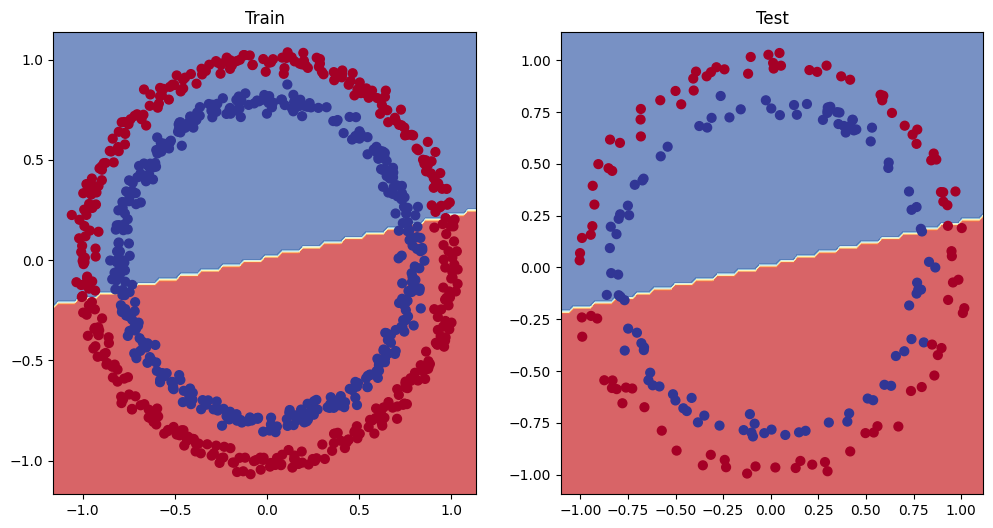

In [117]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,y_test )

In [118]:
# Building a non-linear model
class CircleMethodV3(nn.Module):
  def __init__(self):
    super().__init__()
    #3 Hidden Layers
    self.layer_1 = nn.Linear(in_features=2, out_features=8) # Linear Hidden Layer, takes in 2 inputs
    self.layer_2 = nn.Linear(in_features=8, out_features=8)
    self.layer_3 = nn.Linear(in_features=8, out_features=1)
    self.Relu = nn.ReLU() #Rectified linear unit Activaion function

  def forward(self, x:torch.Tensor):
    z = self.layer_1(x)
    z = self.Relu(z)
    z = self.layer_2(z)
    z = self.Relu(z)
    z = self.layer_3(z)
    return z

In [119]:
model_3 = CircleMethodV3()
model_3

CircleMethodV3(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (Relu): ReLU()
)

In [120]:
# Loss function
loss_fn_3 = nn.BCEWithLogitsLoss()

#opimizer
optimizer_3 = torch.optim.SGD(params= model_3.parameters(), lr = 0.1)

In [122]:
#Train
torch.manual_seed(42)
epoch = 1500
for epoch in range(epoch):
  model_3.train()
  pred_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(pred_logits))

#calculate loss
  loss = loss_fn_3(pred_logits, y_train) #(takes in logits as input)
  acc = accuracy(y_true = y_train, y_pred = y_pred)
#zero the gradient
  optimizer_3.zero_grad()

#Backprogation
  loss.backward()
# step in gradient
  optimizer_3.step()

  model_3.eval()
  with torch.inference_mode():
    #forward pass
    y_test_logit = model_3(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logit))

    # evalaulate the model
    loss_test = loss_fn_3(y_test_logit, y_test)
    test_acc = accuracy(y_true=y_test, y_pred=y_test_pred)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:5f} | Acc: {acc:.2f} | test_acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.692653 | Acc: 50.00 | test_acc: 50.00
Epoch: 100 | Loss: 0.690423 | Acc: 50.75 | test_acc: 56.00
Epoch: 200 | Loss: 0.688876 | Acc: 51.62 | test_acc: 56.00
Epoch: 300 | Loss: 0.686854 | Acc: 52.00 | test_acc: 55.50
Epoch: 400 | Loss: 0.684010 | Acc: 52.38 | test_acc: 56.00
Epoch: 500 | Loss: 0.679671 | Acc: 54.12 | test_acc: 56.50
Epoch: 600 | Loss: 0.672611 | Acc: 60.62 | test_acc: 60.50
Epoch: 700 | Loss: 0.660900 | Acc: 72.12 | test_acc: 74.00
Epoch: 800 | Loss: 0.639534 | Acc: 77.50 | test_acc: 80.50
Epoch: 900 | Loss: 0.597428 | Acc: 87.88 | test_acc: 88.00
Epoch: 1000 | Loss: 0.519894 | Acc: 94.00 | test_acc: 90.50
Epoch: 1100 | Loss: 0.401371 | Acc: 96.50 | test_acc: 94.50
Epoch: 1200 | Loss: 0.265754 | Acc: 98.88 | test_acc: 97.00
Epoch: 1300 | Loss: 0.168364 | Acc: 99.38 | test_acc: 98.00
Epoch: 1400 | Loss: 0.118492 | Acc: 99.62 | test_acc: 98.50


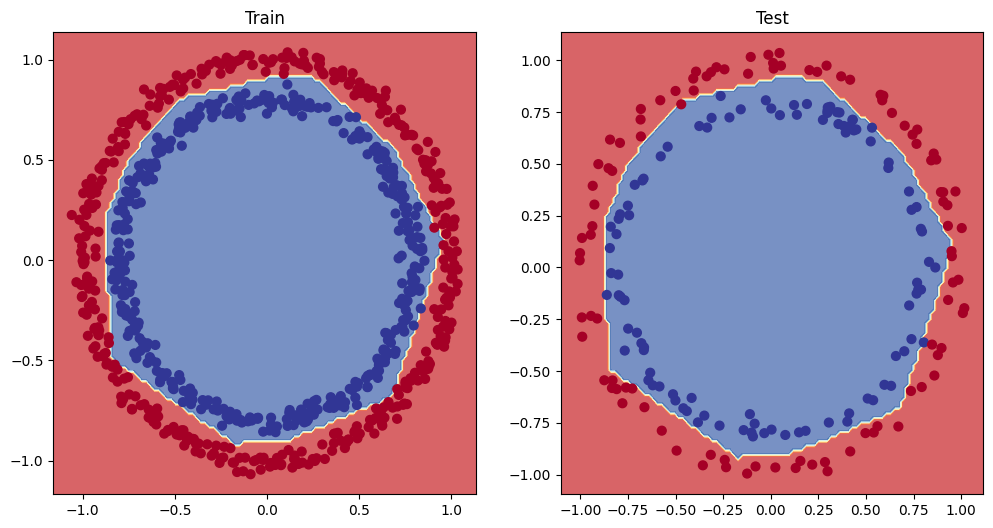

In [123]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test,y_test )